In [1]:
import numpy as np
#import tensorflow as tf
import tensorflow.compat.v1 as tf
tf.disable_eager_execution()

import matplotlib.pyplot as plt
%matplotlib inline

# Load MNIST data
import mnist

In [2]:
def xavier_init(channel_in, channel_out, constant = 1): 
    """
    Xavier initialization of network weights
    """
    
    low = -constant * np.sqrt(6.0 / (channel_in + channel_out)) 
    high = constant * np.sqrt(6.0 / (channel_in + channel_out))
    return tf.random_uniform((channel_in, channel_out), minval = low, maxval = high, dtype=tf.float32)

In [45]:
class VAE(object):
    
    def __init__(self, network_architecture, learning_rate=0.001, batch_size=100):
        """
        Set up the VAE model.
        """
        
        # Set model parameters
        self.network_architecture = network_architecture
        self.lr = learning_rate
        self.batch_size = batch_size
        
        self.x = tf.placeholder(tf.float32, [None, network_architecture["n_input"]])
        
        # Forward pass
        self.forward()
        
        # Backward pass
        self.backward()

        # Initialize the variables and launch the session
        self.sess = tf.InteractiveSession()
        self.sess.run(tf.global_variables_initializer())
        
    def initialize_weights(self, n_hidden_enc_1, n_hidden_enc_2, 
                           n_hidden_dec_1, n_hidden_dec_2, n_hidden_dec_3, n_hidden_dec_4,
                           n_input, n_z):
        """
        Initialize weights of the network layers.
        """
        
        network_weights = dict()
        network_weights['encoder_weights'] = {
            'W1': tf.Variable(xavier_init(n_input, n_hidden_enc_1)),
            'W2': tf.Variable(xavier_init(n_hidden_enc_1, n_hidden_enc_2)),
            'W_mu': tf.Variable(xavier_init(n_hidden_enc_2, n_z)),
            'W_logvar': tf.Variable(xavier_init(n_hidden_enc_2, n_z))}
        network_weights['encoder_bias'] = {
            'b1': tf.Variable(tf.zeros([n_hidden_enc_1], dtype=tf.float32)),
            'b2': tf.Variable(tf.zeros([n_hidden_enc_2], dtype=tf.float32)),
            'b_mu': tf.Variable(tf.zeros([n_z], dtype=tf.float32)),
            'b_logvar': tf.Variable(tf.zeros([n_z], dtype=tf.float32))}
        network_weights['decoder_weights'] = {
            'W1': tf.Variable(xavier_init(n_z, n_hidden_dec_1)),
            'W2': tf.Variable(xavier_init(n_hidden_dec_1, n_hidden_dec_2)),
            'W3': tf.Variable(xavier_init(n_hidden_dec_2, n_hidden_dec_3)),
            'W4': tf.Variable(xavier_init(n_hidden_dec_3, n_hidden_dec_4)),
            'W_out': tf.Variable(xavier_init(n_hidden_dec_4, n_input))}
        network_weights['decoder_bias'] = {
            'b1': tf.Variable(tf.zeros([n_hidden_dec_1], dtype=tf.float32)),
            'b2': tf.Variable(tf.zeros([n_hidden_dec_2], dtype=tf.float32)),
            'b3': tf.Variable(tf.zeros([n_hidden_dec_3], dtype=tf.float32)),
            'b4': tf.Variable(tf.zeros([n_hidden_dec_4], dtype=tf.float32)),
            'b_out': tf.Variable(tf.zeros([n_input], dtype=tf.float32))}
        return network_weights
 

    def encode(self, weights, bias):
        """
        Use the encoder model to map the input data to the latent space.
        """
        
        hidden_1 = tf.nn.relu(tf.add(tf.matmul(self.x, weights['W1']), bias['b1'])) 
        hidden_2 = tf.nn.relu(tf.add(tf.matmul(hidden_1, weights['W2']), bias['b2'])) 
        mu = tf.add(tf.matmul(hidden_2, weights['W_mu']), bias['b_mu'])
        logvar = tf.add(tf.matmul(hidden_2, weights['W_logvar']), bias['b_logvar'])
        return (mu, logvar)

    def decode(self, weights, bias):
        """
        Use the decoder model to reconstruct the input data.
        """
        
        hidden_1 = tf.nn.leaky_relu(tf.add(tf.matmul(self.z, weights['W1']), bias['b1'])) 
        hidden_2 = tf.nn.leaky_relu(tf.add(tf.matmul(hidden_1, weights['W2']), bias['b2'])) 
        hidden_3 = tf.nn.leaky_relu(tf.add(tf.matmul(hidden_2, weights['W3']), bias['b3'])) 
        hidden_4 = tf.nn.leaky_relu(tf.add(tf.matmul(hidden_3, weights['W4']), bias['b4'])) 
        recon_x = tf.nn.sigmoid(tf.add(tf.matmul(hidden_4, weights['W_out']), bias['b_out']))
        return recon_x
    
    
    def forward(self):
        """
        Build the VAE network.
        """
        
        # Initialize weights and bias
        network_weights = self.initialize_weights(**self.network_architecture)

        # Use encoder model to obtain latent z
        self.mu, self.logvar = self.encode(network_weights["encoder_weights"], 
                                      network_weights["encoder_bias"])

        # Draw sample z from Gaussian using reparametrization trick
        n_z = self.network_architecture["n_z"]
        eps = tf.random_normal((self.batch_size, n_z), 0, 1, dtype=tf.float32)
        self.z = tf.add(self.mu, tf.multiply(tf.sqrt(tf.exp(self.logvar)), eps))

        # Use decoder model to obtain the reconstructed input
        self.recon_x = self.decode(network_weights["decoder_weights"],
                                    network_weights["decoder_bias"])
            
            
    def backward(self):
        """
        Calculate gradients using backpropagation and update weights using Adam optimizer.
        """
        
        rec_loss = - tf.reduce_sum(self.x * tf.log(1e-8 + self.recon_x)
                           + (1 - self.x) * tf.log(1e-8 + 1 - self.recon_x), 1)
      
        kl = -0.5 * tf.reduce_sum(1 + self.logvar - tf.square(self.mu) - tf.exp(self.logvar), 1)
        
        self.loss = tf.reduce_mean(rec_loss + kl)   
       
        self.optimizer = tf.train.AdamOptimizer(learning_rate = self.lr).minimize(self.loss)
        
    def train(self, X):
        """
        Train model based on mini-batch of input data.
        Return loss of mini-batch.
        """
        
        opt, loss = self.sess.run((self.optimizer, self.loss), 
                                                feed_dict={self.x: X})
        return loss
    
    def evaluate(self, X, recon_X):
        """
        Evaluate the accuracy of the model with reconstruction error and marginal log-likelihood.
        """
        rec_loss = BCE(recon_X, X) / len(X)
        # Marginal log-likelihood of data = - ELBO
        marg_likelihood = - self.train(X)
        
        return rec_loss, marg_likelihood
    
    def transform(self, X):
        """
        Transform data by mapping it into the latent space.
        """
        # Note: This maps to mean of distribution, we could alternatively sample from Gaussian distribution
        return self.sess.run((self.mu, self.logvar), feed_dict={self.x: X})
    
    def transform1d(self, X):
        """
        Transform data by mapping it into the latent space.
        """
        # Note: This maps to mean of distribution, we could alternatively sample from Gaussian distribution
        return self.sess.run(self.mu, feed_dict={self.x: X})
    
    def generate(self, mu = None):
        """ 
        Generate data by sampling from the latent space.        
        """
        if mu is None:
            # Data is alternatively generated from the prior in the latent space
            mu = np.random.normal(size = self.network_architecture["n_z"])

        return self.sess.run(self.recon_x, feed_dict={self.z: mu})
    
    def reconstruct(self, X):
        """ 
        Reconstruct the given input data. 
        """
        
        return self.sess.run(self.recon_x, feed_dict={self.x: X})

In [4]:
from scipy.io import loadmat
from sklearn.preprocessing import normalize

In [5]:
dat_mat = loadmat('./vae/data/HCP_subcortical_CMData_desikan.mat')
tensor = dat_mat['loaded_tensor_sub']
network_ids = dat_mat['all_id'].reshape(-1)

In [6]:
#offset = 100 

net_data = []
for i in range(tensor.shape[3]):
    ith = np.float32(tensor[:,:,0,i] + np.transpose(tensor[:,:,0,i])) # [:,:,0,:] - network data
    #ith = ith/offset
    ith = ith[18:86, 18:86]
    ith = ith.flatten()
    net_data.append(ith)

In [7]:
brain_graphs = np.stack(net_data)
brain_graphs = normalize(brain_graphs) # Normalize data
print(brain_graphs.shape)

(1065, 4624)


In [182]:
###Load phenotypes 
#trait_mat = loadmat('./vae/data/HCP_Covariates.mat')
#trait_ids = trait_mat['allsubject_id']
# Match trait_ids with subject's network_ids
#trait_data = (trait_mat['cog_measure'])[:, np.isin(trait_ids, network_ids)]
phen_dat = loadmat('./vae/data/HCP_Covariates.mat')
phen_idx = [np.where(phen_dat['allsubject_id'] == ival)[0] for ival in dat_mat['all_id'].squeeze()]
trait_data = phen_dat['cog_measure'][4, phen_idx]
trait = trait_data[~np.isnan(trait_data)]

#trait = trait_data[4,:]
# Replace nan with 0
#trait[np.isnan(trait)] = 0
#trait = (trait-np.mean(trait))/np.std(trait)
print(trait.shape)
# 4 - Oral Reading Recognition Test
# 6 - Picture Vocabulary Test 
# 24 - Line Orientation: Total number correct
# 26 - Line Orientation: Total positions off for all trials 

(1065,)


In [8]:
def train_brain_graphs(network_architecture, 
                    learning_rate=0.001, batch_size=6, n_epoch=10):
    """
    Train the VAE model on the Brain Connectomes data set.
    """
    
    vae = VAE(network_architecture, learning_rate=learning_rate, batch_size=batch_size)
    
    train_data = brain_graphs 
    train_size = train_data.shape[0]
    
    for epoch in range(n_epoch):
        
        avg_loss = 0.
        n_batch = int(train_size / batch_size) 

        for idx in range(n_batch):
            train_batch = train_data[idx * batch_size:idx * batch_size + batch_size]
            loss = vae.train(train_batch)
            avg_loss += loss / train_size * batch_size

        print("Epoch:", "%d/%d" % (epoch+1, n_epoch), 
              "Loss =", "{:.4f}".format(avg_loss))
        
    return vae

In [ ]:
network_architecture = dict(n_hidden_enc_1 = 500, 
                             n_hidden_enc_2 = 500, 
                             n_hidden_dec_1 = 500, 
                             n_hidden_dec_2 = 1000, 
                             n_hidden_dec_3 = 2000, 
                             n_hidden_dec_4 = 3000,
                             n_input = 68 * 68, 
                             n_z = 200)  

vae = train_brain_graphs(network_architecture, n_epoch = 30)

In [183]:
y_idx = np.argsort(trait)
y_idx_100 = np.concatenate([y_idx[:100], y_idx[-100:]])
label = np.concatenate([np.zeros(100), np.ones(100)])
y_color = trait[y_idx_100]

In [101]:
from sklearn.decomposition import PCA
#from sklearn.manifold import TSNE
from mpl_toolkits.mplot3d import Axes3D

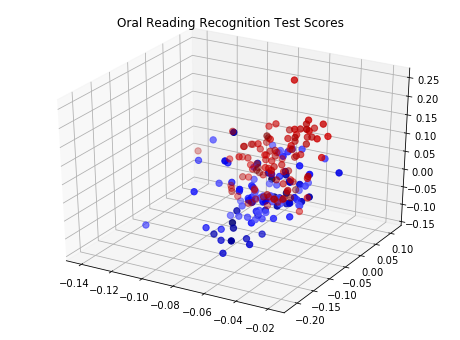

In [186]:
X_trait4 = np.load('mu4.npy')
X_100 = X_trait4[y_idx_100, :]

pca = PCA(n_components=3)
pca.fit(X_100.transpose())
pca_results = pca.components_.transpose()

fig = plt.figure(figsize=(8, 6))
ax = fig.gca(projection='3d')
cm = plt.cm.get_cmap('seismic')
ax.scatter(pca_results[:,0], pca_results[:,1], pca_results[:,2], 
           c=y_color, s=40, cmap=cm)
ax.view_init(30, 300)
plt.title("Oral Reading Recognition Test Scores")
ax.grid()

In [116]:
y_idx = np.argsort(trait)
y_idx_100 = np.concatenate([y_idx[:100], y_idx[-100:]])
label = np.concatenate([np.zeros(100), np.ones(100)])
y_color = trait[y_idx_100]

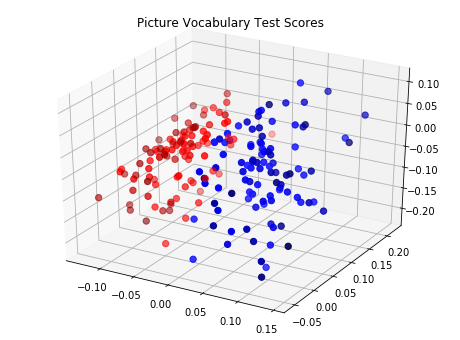

In [124]:
X_trait6 = np.load('mu6.npy')
X_100 = X_trait6[y_idx_100, :]

pca = PCA(n_components=3)
pca.fit(X_100.transpose())
pca_results = pca.components_.transpose()

fig = plt.figure(figsize=(8, 6))
ax = fig.gca(projection='3d')
cm = plt.cm.get_cmap('seismic')
ax.scatter(pca_results[:,0], pca_results[:,1], pca_results[:,2], 
           c=y_color, s=40, cmap=cm)
ax.view_init(30, 300)
plt.title("Picture Vocabulary Test Scores")
ax.grid()

In [170]:
y_idx = np.argsort(trait)
y_idx_100 = np.concatenate([y_idx[:100], y_idx[-100:]])
label = np.concatenate([np.zeros(100), np.ones(100)])
y_color = trait[y_idx_100]

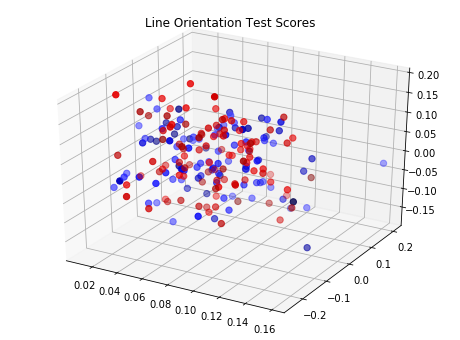

In [181]:
X_trait24 = np.load('mu.npy')
X_100 = X_trait24[y_idx_100, :]

pca = PCA(n_components=3)
pca.fit(X_100.transpose())
pca_results = pca.components_.transpose()

fig = plt.figure(figsize=(8, 6))
ax = fig.gca(projection='3d')
cm = plt.cm.get_cmap('seismic')
ax.scatter(pca_results[:,0], 
           pca_results[:,1], 
           pca_results[:,2], 
           c=y_color, s=40, cmap=cm)
ax.view_init(30, 300)
plt.title("Line Orientation Test Scores")
ax.grid()